## Making ends meet: Projecting demand for class seats at a major American university

One of the biggest challenges facing university administrators and department heads is meeting the needs of its students. As a business, a university's operations are funded by student tuition dollars. If we carry the business analogy forward, this necessitates a service or product rended by the university to/for the students. Guaranteed space in the classes required to obtain a desired degree could naturally be thought of as the product a student receives for her tuition money. 

However, actually providing those seats in a balanced, informed manner requires calculation. An additional challenge comes with the knowledge that each class behaves independently of other classes (i.e. a 100-level general elective course has markedly different enrollment history than a 400-level seminar for upperclassmen). Semester types, too, embody different patterns (i.e. a pattern of enrollment for a fall semester differs from that for a summer semester); in the current project, we'll explore the latter in-depth to illustrate the varying behavior. 


### The data

This project incorporates data from the last 30 academic years for ENGL101, a 100-level, general-education course required to complete a bachelors degree of any kind at the University of Arizona. Knowing the "core" status of this class, we can characterize this class as one that many incoming freshmen will take and that many will likely seek to complete early on in their undergraduate careers so that they can move on to more specific courses of interest later in their academic tenure.

In the future, such a tool as this could be used to project seats for different class types (i.e. lower- versus upper-level classes; general-education versus not; type of semester). By projecting seats at the level of each individual class, we can remove noise from the data, namely tailoring each projection to fit best to the class for which it's being calculated. 

Further, in this project, I also demonstrate how the model can be used to project seats in different semesters. This model was designed this way--to estimate seats for a particular class in a particular semester--to facilitate the removal of known sources of noise and separating time periods in ways motivated by a-priori knowledge that different semesters embody different enrollment behavior. In order to ensure precision and minimize the effects of noise at an aggregated level, users of this tool will be able to choose from a list of prompts their class and term of interest.  

### Getting and cleaning the data

The data used here contains no identifiable information. Data is aggregated at the level of class enrollment and cannot be traced back to the level of any particular student. 

With two separate SQL queries, I pulled class enrollment data for ENGL101 at the level of the semester. At the 21st day in the semester, student-level data is captured in a snapshot, where information such as number of students enrolled in the course is "snapped" and saved in the snapshot; this 21st day is called a census.  

From this census data, I included data from fall, summer, and spring semesters--ENGL101 hasn't been offered in winter term in the last 30 years. For this reason, winter-semester data has been excluded in this analysis.

I exported the class enrollment counts data here to be read in with pandas for the data wrangling component.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2
import scipy
from math import sqrt
from pandas.tools.plotting import lag_plot
from scipy import stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR

In [2]:
engl_semester_counts = pd.read_excel("ENGL101_enrollment_1881-2184.xlsx", sheet_name='BY-SEMESTER', header=0)
engl_semester_counts = engl_semester_counts.rename(
    columns={'TERM_CD':'TERM_CODE','SBJCT_CD':'SUBJECT_CODE','SBJCT_LD':'SUBJECT_DESCRIPTION'}
)
engl_semester_counts.head()

,TERM_CODE,SEMESTER_TYPE,YEAR,TERM,SUBJECT_CODE,SUBJECT_DESCRIPTION,CATALOG_NBR,ENROLLED
0,1881,Spring,1988,Spring 1988,ENGL,English Main,101,1119
1,1882,Summer,1988,Summer 1988,ENGL,English Main,101,183
2,1884,Fall,1988,Fall 1988,ENGL,English Main,101,3321
3,1891,Spring,1989,Spring 1989,ENGL,English Main,101,1039
4,1892,Summer,1989,Summer 1989,ENGL,English Main,101,175


In [3]:
fall_semester_counts = engl_semester_counts[engl_semester_counts.SEMESTER_TYPE == 'Fall']
summer_semester_counts = engl_semester_counts[engl_semester_counts.SEMESTER_TYPE == 'Summer']
spring_semester_counts = engl_semester_counts[engl_semester_counts.SEMESTER_TYPE == 'Spring']

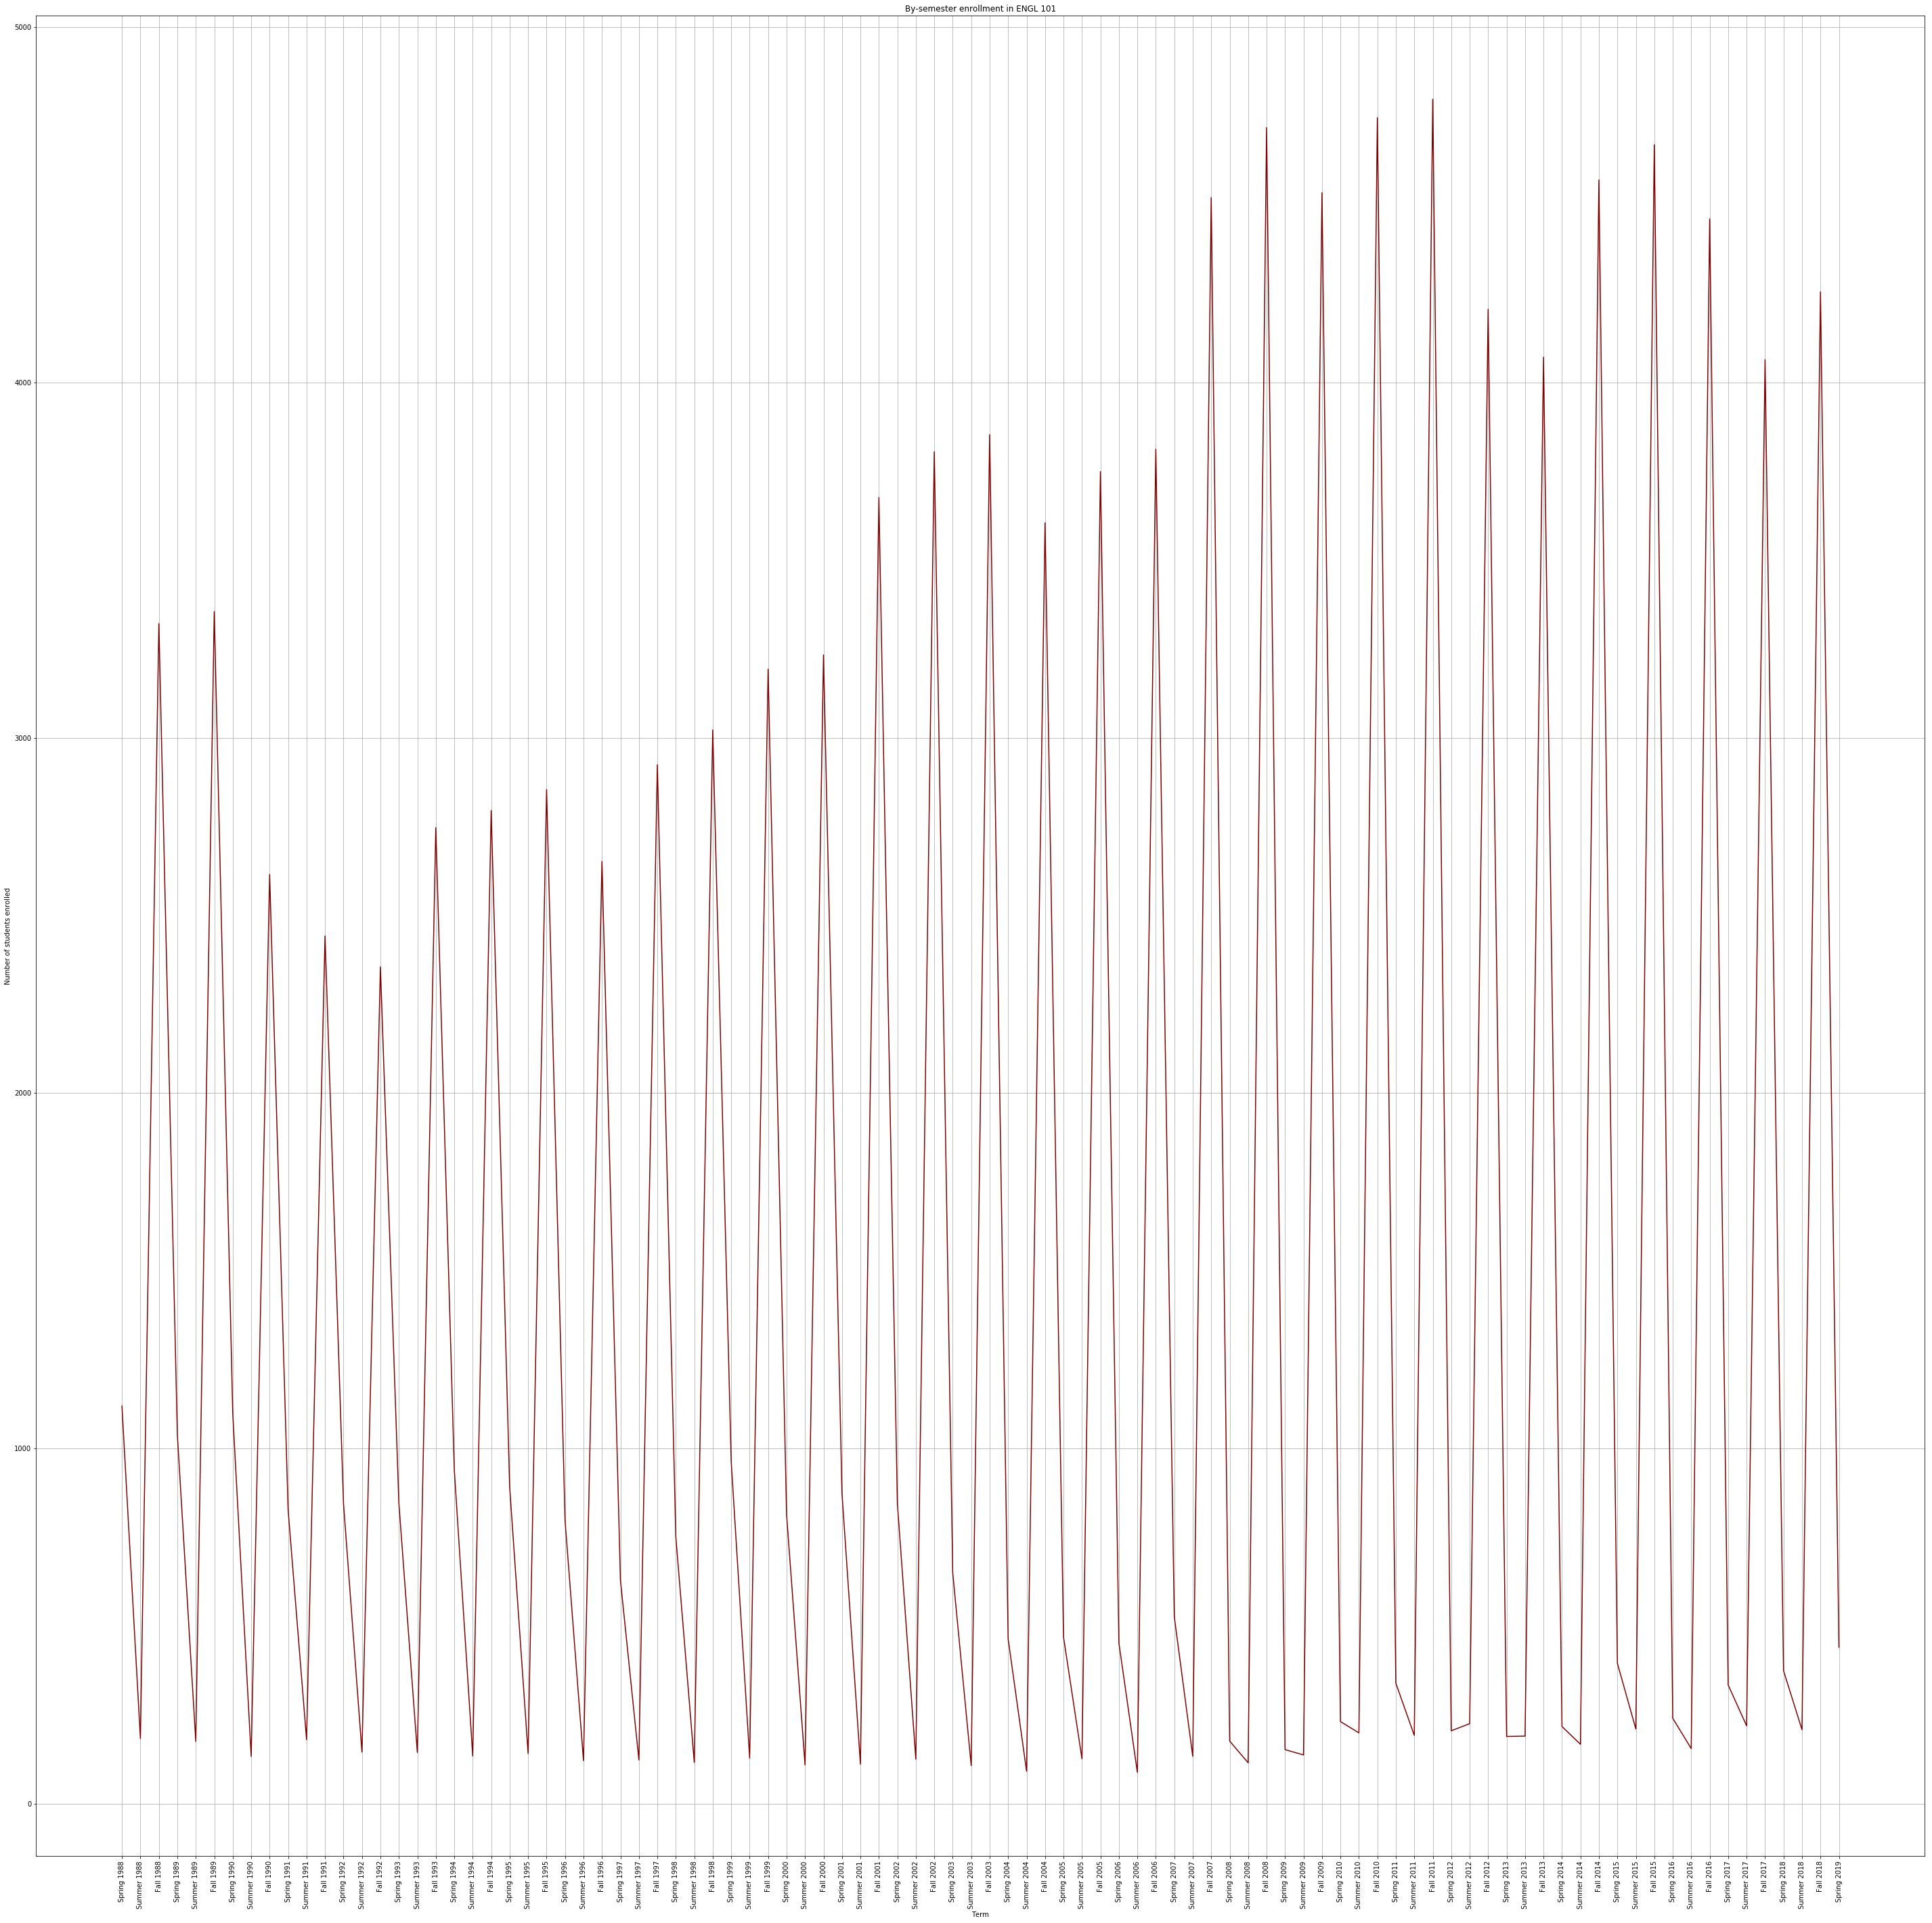

In [4]:
fig, ax = plt.subplots(figsize=(50,50))
ax.plot(engl_semester_counts.TERM, engl_semester_counts.ENROLLED, color = 'maroon')
ax.set(xlabel = 'Term', ylabel = 'Number of students enrolled',
      title = 'By-semester enrollment in ENGL 101')
ax.set_xticklabels(engl_semester_counts.TERM, rotation='vertical')
#ax.set_ylim(bottom = 0, top = 150)
ax.grid()
plt.show()

The data by-semester demonstrates sharp peaks with a clear periodicity and interval. Looking closer, we see that these peaks come at every fall semester. This is unsurprising: ENGL 101 is a general-education requirement for any bachelors degree (arts and science) and is commonly taken by first-year students in their first-semester. For most, this first semester is a fall term.

From a forecasting perspective, we could build a model that calculates the trend and seasonality and retain all of the datapoints in the same model. From a narrative perspective, this might be motivated by the desire to see how enrollment changes over the course of the academic year. However, we should also look at the data at a by-semester grain in the spirit of comprehensive EDA. 

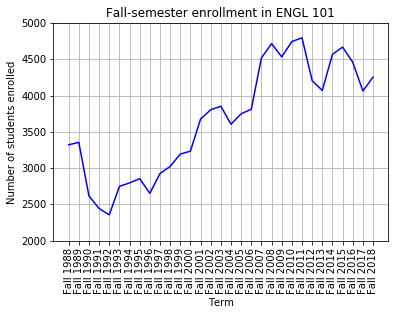

In [5]:
fig, ax = plt.subplots()
ax.plot(fall_semester_counts.TERM, fall_semester_counts.ENROLLED, color = 'blue')
ax.set(xlabel = 'Term', ylabel = 'Number of students enrolled',
      title = 'Fall-semester enrollment in ENGL 101')
ax.set_xticklabels(fall_semester_counts.TERM, rotation='vertical')
ax.set_ylim(bottom = 2000, top = 5000)
ax.grid()
plt.show()

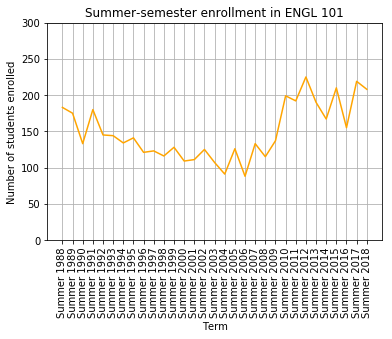

In [6]:
fig, ax = plt.subplots()
ax.plot(summer_semester_counts.TERM, summer_semester_counts.ENROLLED, color = 'orange')
ax.set(xlabel = 'Term', ylabel = 'Number of students enrolled',
      title = 'Summer-semester enrollment in ENGL 101')
ax.set_xticklabels(summer_semester_counts.TERM, rotation='vertical')
ax.set_ylim(bottom = 0, top = 300)
ax.grid()
plt.show()

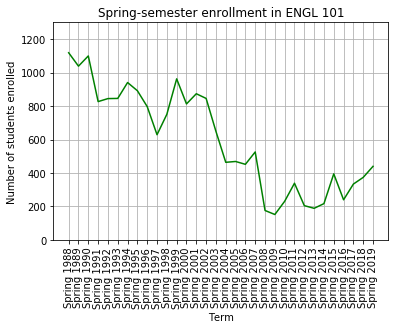

In [7]:
fig, ax = plt.subplots()
ax.plot(spring_semester_counts.TERM, spring_semester_counts.ENROLLED, color = 'green')
ax.set(xlabel = 'Term', ylabel = 'Number of students enrolled',
      title = 'Spring-semester enrollment in ENGL 101')
ax.set_xticklabels(spring_semester_counts.TERM, rotation='vertical')
ax.set_ylim(bottom = 0, top = 1300)
ax.grid()
plt.show()

### The application

When going in to estimate the number of seats needed in a course per term, I anticipate that a department head or administrator will have the following parameters specified: 1) the term for which the seats will be needed; and 2) the specific course.  

With these usability parameters in mind, we will move forward with subsetting the data by semester with the aim of improving model accuracy--e.g. less noise from other semesters--and facilitating specificity for what class the projections will be used for.

### Choosing the model

Statistically, we know that a simple Ordinary Least Squares regression is inappropriate in this scenario based on the assumptions of OLS. Namely, OLS assumes that the predicted value can take on any form, for example, an integer or fraction, a positive or negative value. While enrollment could potentially be 0, it can never be a negative number. Also, enrollment data is count data and therefore can never be a fraction. 

#### Autoregression

Considering the data being used, <b><i>time-series analysis</i></b> is most appropriate, as univariate time-series modelling allows for a potentially underlying structure in the data (i.e. trend, seasonality). There are a few different variations and combinations of time-series approaches to consider. First, a simple <b>AR, or auto-regressive, model</b>, could be of value, and is defined as:
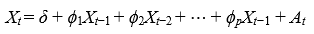

Autoregression is a linear approach where the current value in a series is regressed against the series' previous value or values. <i>X</i> represents the time series, with <i>t</i> indicating particular values in the series; <i>A</i> represents the white noise; and <i>δ</i> represents the process mean. The order of the AR model is represented by p.

#### Stationarity testing

To assess <b>stationarity</b> of the time series, descriptive statistics were used. Namely, the data were bisected, and the means and variances were calculated for both pieces. If a dataset demonstrates stationarity, the means and variances should be similar. 

In [8]:
fall_points = fall_semester_counts.ENROLLED

split = int(len(fall_points)/2)
fall_x1, fall_x2 = fall_points[0:split], fall_points[split:]
fall_mean1, fall_mean2 = fall_x1.mean(), fall_x2.mean()
fall_var1, fall_var2 = fall_x1.var(), fall_x2.var()
print('mean 1 = %f, mean 2 = %f' % (fall_mean1, fall_mean2))
print('variance 1 = %f, variance 2 = %f' % (fall_var1, fall_var2))

mean 1 = 2999.266667, mean 2 = 4289.187500
variance 1 = 182566.066667, variance 2 = 153229.762500


In [9]:
summer_points = summer_semester_counts.ENROLLED

split = int(len(summer_points)/2)
summer_x1, summer_x2 = summer_points[0:split], summer_points[split:]
summer_mean1, summer_mean2 = summer_x1.mean(), summer_x2.mean()
summer_var1, summer_var2 = summer_x1.var(), summer_x2.var()
print('mean 1 = %f, mean 2 = %f' % (summer_mean1, summer_mean2))
print('variance 1 = %f, variance 2 = %f' % (summer_var1, summer_var2))

mean 1 = 137.866667, mean 2 = 160.125000
variance 1 = 580.695238, variance 2 = 2214.783333


In [10]:
spring_points = spring_semester_counts.ENROLLED

split = int(len(spring_points)/2)
spring_x1, spring_x2 = spring_points[0:split], spring_points[split:]
spring_mean1, spring_mean2 = spring_x1.mean(), spring_x2.mean()
spring_var1, spring_var2 = spring_x1.var(), spring_x2.var()
print('mean 1 = %f, mean 2 = %f' % (spring_mean1, spring_mean2))
print('variance 1 = %f, variance 2 = %f' % (spring_var1, spring_var2))

mean 1 = 870.687500, mean 2 = 325.187500
variance 1 = 19395.429167, variance 2 = 15342.695833


Testing for stationarity in all three subsets of the ENGL101 data, we see this data is strongly <b>not stationary</b>. A mathematical remedy we can use to make the data stationary is <b>differencing</b>, a step we will return to below when discussing the ARIMA model. 

Before we consider a more complex model (spoiler alert: We will below), it will be instructive to see how a very simple model instantiation performs. First, we need to check that the underlying assumptions are met, for example, that the data are <i>normally distributed</i>. I conducted a Shapiro-Wilks test to investigate this assumption in the fall data.

In [11]:
x = fall_semester_counts.ENROLLED
shapiro_stat, shapiro_p = scipy.stats.shapiro(x)
print('Statistic=%.3f, p=%.3f' % (shapiro_stat, shapiro_p))

Statistic=0.940, p=0.083


Results suggest that while the test statistic is approaching significance, ultimately it does not surpass our threshold of .05 for significance. With this finding, we can conclude that the fall enrollment data by-semester approximates a Gaussian distribution, and we can proceed by treating the data parametrically. 

Sometimes, when using time-series analyses, because of the nature of the data--i.e. one data point is related, often, in some way to the preceding or following observation--we see what's called autocorrelation. Visually, such a reality would manifest as datapoints appearing correlated to one another, exhibiting a clear visual trend. We can investigate this in the semester-level data by constructing autocorrelation plots.

C:\Users\Megabean\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  """Entry point for launching an IPython kernel.


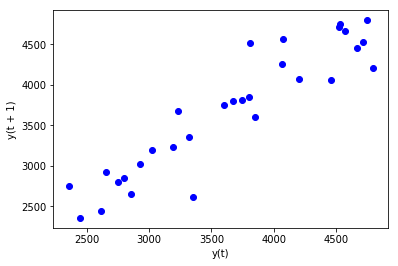

In [12]:
lag_plot(fall_semester_counts.ENROLLED, c = 'b')
plt.show()

C:\Users\Megabean\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  """Entry point for launching an IPython kernel.


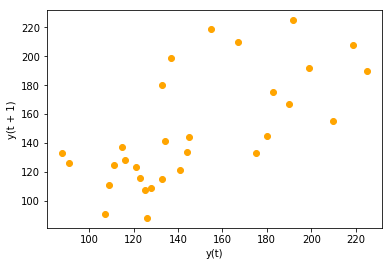

In [13]:
lag_plot(summer_semester_counts.ENROLLED, c = 'orange')
plt.show()

C:\Users\Megabean\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  """Entry point for launching an IPython kernel.


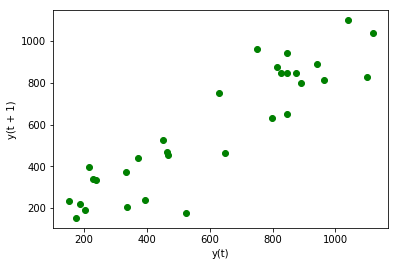

In [14]:
lag_plot(spring_semester_counts.ENROLLED, c = 'green')
plt.show()

However, after plotting all three of our different semester types' worth of data, we only see tangential visual evidence of this. While the datapoints show some relationship (i.e. trend), they are not strongly correlated. Scrolling back up, the line graphs of the three semesters' data corroborates this. 

### Train-test split

Knowing that there are 31 observations in the fall dataset (and, similarly, 31 observations in the summer and 32 in the spring), we can use a 70/30 ratio to split the data for training and testing purposes.

We'll pilot the AR model using the fall data only. As we'll see later, there are more appropriate models that will be used on the full ENGL101 dataset. 

In [15]:
len(fall_semester_counts)

31

In [16]:
len(fall_semester_counts)*.70

21.7

In [17]:
# Split the data into training and testing datasets
X = fall_semester_counts.ENROLLED
train, test = X[1:len(X)-10], X[len(X)-10:]

In [18]:
# Fit autoregression model
fall_model = AR(train)
fall_model_fit = fall_model.fit()
print('Lag: %s' % fall_model_fit.k_ar)
print('Coefficients: %s' % fall_model_fit.params)

test_values = [value for value in test]

# Make predictions
predictions = fall_model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

predictions = [value for value in predictions]


Lag: 8
Coefficients: const         -229.069669
L1.ENROLLED      0.641138
L2.ENROLLED      0.594103
L3.ENROLLED     -1.858331
L4.ENROLLED      1.427287
L5.ENROLLED     -0.250766
L6.ENROLLED     -0.433215
L7.ENROLLED      1.423502
L8.ENROLLED     -0.293738
dtype: float64


C:\Users\Megabean\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Megabean\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [19]:
error = mean_squared_error(test_values, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 4528764.060


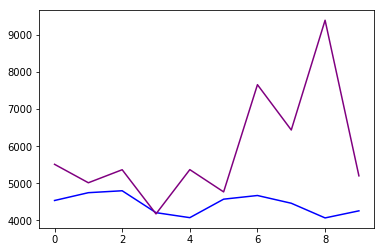

In [20]:
# Plot results
plt.plot(test_values, color = 'blue')
plt.plot(predictions, color='purple')
plt.show()

Visualization of the fall model output isn't encouraging, and the MSE is enormous. This model is clearly underfit, and in fact, seems to be making superfluous predictions farther out in time.

However, knowing what we do about autoregression, this isn't surprising. For example, autogression is often used to model random processes that vary with time. While enrollment can be affected by a number of factors, it would be difficult to argue that enrollment is random. At the aggregate, we know generally that enrollment will be within a particular range based on the number of students currently enrolled as well as those coming in for a given semester. Further, we know that autoregression is based in a linear model. Plots provided above show evidence against the assumption that the relationship among the enrollment datapoints is a linear one.  

#### Auto-regressive, integrated, moving-average (ARIMA)

A more appropriate model we should consider is the full <b>ARIMA, or auto-regressive, integrated, moving-average, model</b>, defined as:

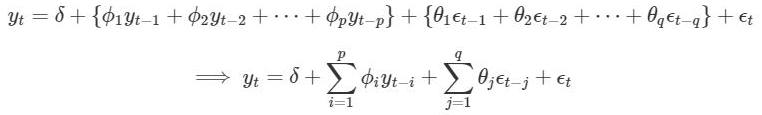

An ARIMA model incorporates three components: 1) the auto-regressive piece from the AR model tried above; 2) a differencing step needed to remove any degree of seasonality from the data; and 3) a moving-average piece, which uses an average of the datapoints in the specified window to calculate estimations for future time points.

Conceptually, it makes more sense to employ an ARIMA for our data, knowing there very well may be both trend and seasonality in the enrollment data. Specifically, it can help us to capture the pattern of the data, while more effectively capture the variation over time by allowing a non-constant mean. 

To incorporate an ARIMA, <b>we'll try two approaches</b>. First, we'll hand-select parameters <i>p, d, q</i> and compare three different instantiations of the ARIMA based on informative visualizations--ACF and PACF plots. Then, we'll try out the auto-ARIMA approach offered by the <i>forecast</i> package in R to see how the model we chose by hand compares with the model selected by automation.  

#### ARIMA, by-hand

Returning to the idea of <b>stationarity</b>, in order to make the data stationary and remove the trend component, we need to take a difference and keep taking differences until the trend is removed. The number of times it takes to do this will be the <i>d</i> parameter of the ARIMA.

In [21]:
%load_ext rpy2.ipython

C:\Users\Megabean\Anaconda3\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


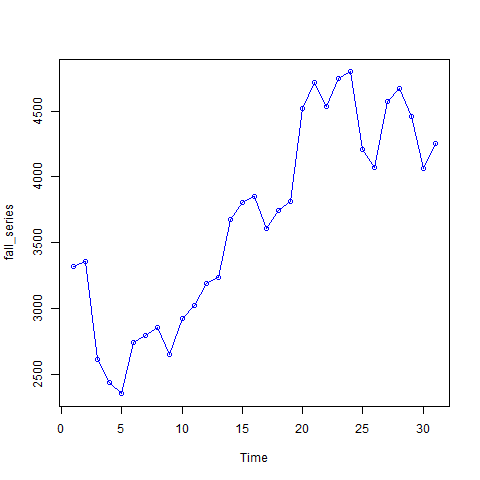

In [22]:
%%R -i fall_semester_counts

# Set up a time-series object for the fall data
fall_series <- ts(fall_semester_counts$ENROLLED)

# Difference the fall data once
diff_fall_series <- diff(fall_series)

# Plot the original data
plot(fall_series, type="o", col="blue")


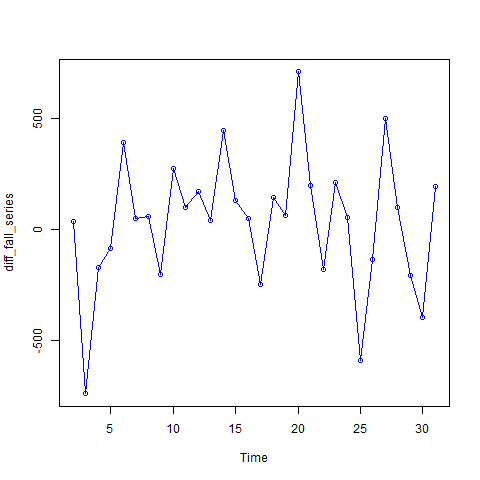

In [23]:
%%R

# Plot the differenced data
plot(diff_fall_series, type="o", col="blue")

After one differencing, the trend component of the fall data looks to have been removed. As a conservative approach, we can stop with one differencing. For the ARIMA, this will give d = 1. 

We can repeat these steps for the summer and spring data.

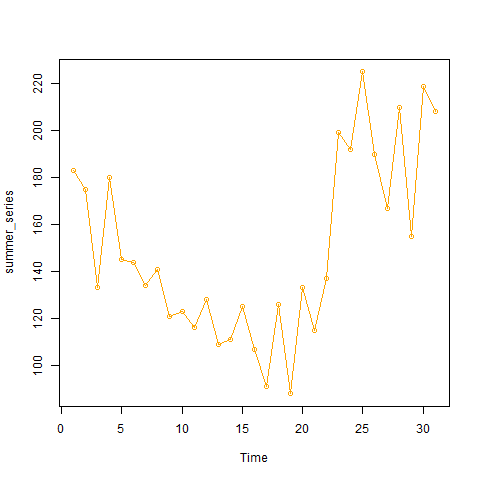

In [24]:
%%R -i summer_semester_counts

# Set up a time-series object for the summer data
summer_series <- ts(summer_semester_counts$ENROLLED)

# Difference the summer data once
diff_summer_series <- diff(summer_series)

# Plot the original summer data
plot(summer_series, type="o", col="orange")


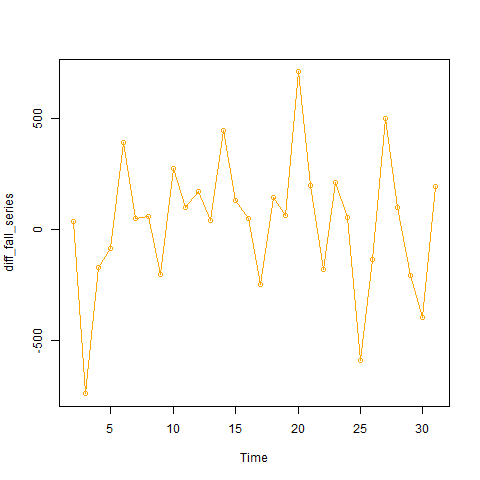

In [25]:
%%R

# Plot the differenced summer data
plot(diff_fall_series, type="o", col="orange")

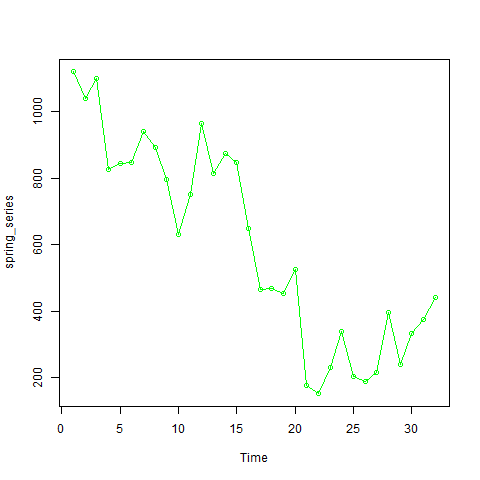

In [26]:
%%R -i spring_semester_counts

# Set up a time-series object for the spring data
spring_series <- ts(spring_semester_counts$ENROLLED)

# Difference the spring data once
diff_spring_series <- diff(spring_series)

# Plot the original spring data
plot(spring_series, type="o", col="green")


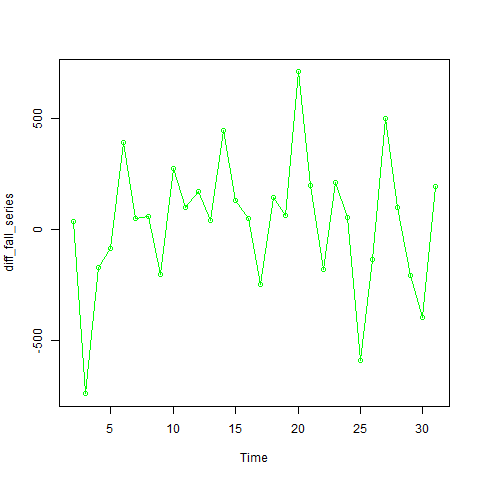

In [27]:
%%R

# Plot the differenced spring data
plot(diff_fall_series, type="o", col="green")

After choosing a value for <i>d</i> parameter, we need <i>p</i> and <i>q</i>. For <i>p</i>, we'll use a partial auto-correlation plot to see after how many lags, we see a drop-off. That drop-off point will be the value we choose for the <i>p</i>, the ARIMA's AR parameter. For the model's AM parameter, <i>q</i>, we'll look at an auto-correlation plot of the differenced data for each semester for a similar cut-off point.

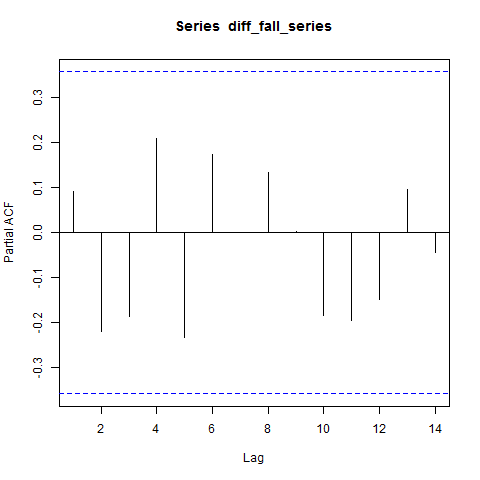

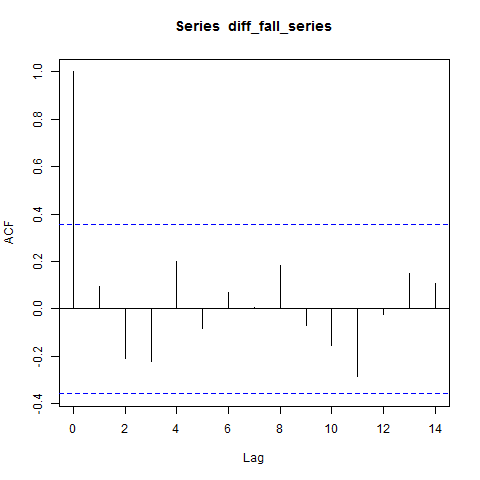

In [28]:
%%R

pacf(diff_fall_series)
acf(diff_fall_series)

For the fall data, both the PACF and ACF plots show a cut-off after 1 lag, so for the fall ARIMA, we'll specify that <i>p</i> = 1 and <i>q</i> = 1.

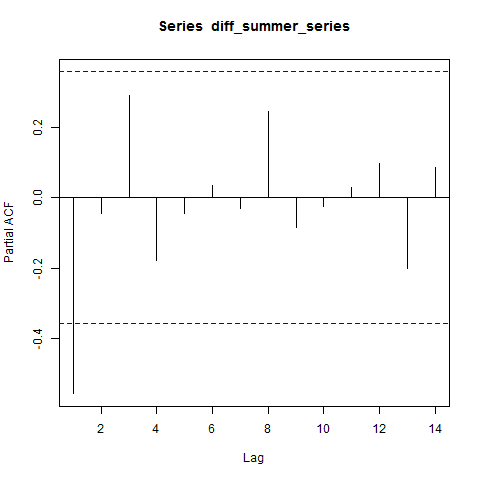

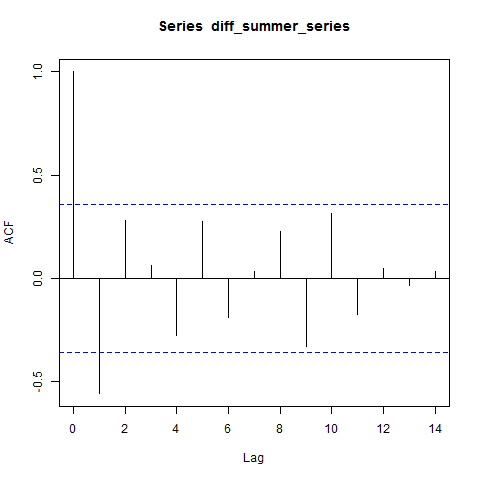

In [29]:
%%R

pacf(diff_summer_series)
acf(diff_summer_series)

For the summer data, we see no cut-off in the PACF, but a sharp cut-off after 1 in the ACF. For the summer data, we'll specify that <i>p</i> = 0 and <i>q</i> = 1.

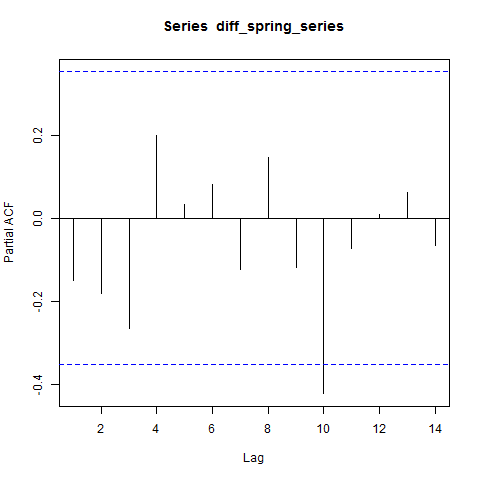

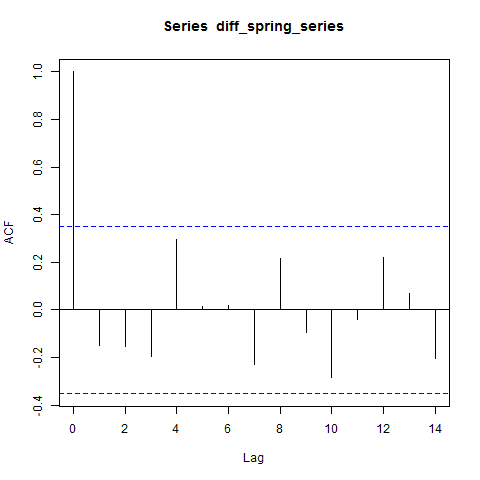

In [30]:
%%R

pacf(diff_spring_series)
acf(diff_spring_series)

The spring data is similar to the summer data, in that we see no cut-off in the PACF, but again the sharp cut-off after 1 in the ACF. We'll use the same parameters as we did for the summer data, <i>p</i> = 0 and <i>q</i> = 1.

With these parameters in mind, <b>we'll test three separate models for the fall data and two models for the summer and spring data.</b> For the fall data, we'll test ARIMA(0,1,1), ARIMA(1,1,0), and ARIMA(1,1,1). For each of the summer and spring data, we'll test ARIMA(0,1,0) and ARIMA(0,1,1).

In [31]:
%%R -o fall_arimaModel_1

fall_train_series = fall_series[1:22]
fall_test_series = fall_series[23:31]

fall_arimaModel_1 = arima(fall_train_series, order=c(0,1,1))

In [32]:
%%R -o fall_arimaModel_2

fall_train_series = fall_series[1:22]
fall_test_series = fall_series[23:31]

fall_arimaModel_2 = arima(fall_train_series, order=c(1,1,0))

In [33]:
%%R -o fall_arimaModel_3

fall_train_series = fall_series[1:22]
fall_test_series = fall_series[23:31]

fall_arimaModel_3 = arima(fall_train_series, order=c(1,1,1))

In [34]:
print(fall_arimaModel_1)
print(fall_arimaModel_2)
print(fall_arimaModel_3)



Call:

arima(x = fall_train_series, order = c(0, 1, 1))



Coefficients:

         ma1

      0.1284

s.e.  0.1846



sigma^2 estimated as 82739:  log likelihood = -148.7,  aic = 301.4



Call:

arima(x = fall_train_series, order = c(1, 1, 0))



Coefficients:

         ar1

      0.1530

s.e.  0.2122



sigma^2 estimated as 82437:  log likelihood = -148.67,  aic = 301.33



Call:

arima(x = fall_train_series, order = c(1, 1, 1))



Coefficients:

         ar1      ma1

      0.1803  -0.0281

s.e.  0.6483   0.6349



sigma^2 estimated as 82429:  log likelihood = -148.67,  aic = 303.33



The second model instantiation for the fall data, <b>ARIMA(1,1,0)</b> returns the best AIC of the three hand-selected model parameter groupings.

In [35]:
%%R -o summer_arimaModel_1

summer_train_series = summer_series[1:22]
summer_test_series = summer_series[23:31]

summer_arimaModel_1 = arima(summer_train_series, order=c(0,1,0))

In [36]:
%%R -o summer_arimaModel_2

summer_train_series = summer_series[1:22]
summer_test_series = summer_series[23:31]

summer_arimaModel_2 = arima(summer_train_series, order=c(0,1,1))

In [37]:
print(summer_arimaModel_1)
print(summer_arimaModel_2)



Call:

arima(x = summer_train_series, order = c(0, 1, 0))





sigma^2 estimated as 602.5:  log likelihood = -97.01,  aic = 196.02



Call:

arima(x = summer_train_series, order = c(0, 1, 1))



Coefficients:

          ma1

      -0.5598

s.e.   0.1389



sigma^2 estimated as 375:  log likelihood = -92.22,  aic = 188.44



Of the two versions we tested for the summer data, the second instantiation, <b>ARIMA(0,1,1)</b>, returns the best AIC.

In [38]:
%%R -o spring_arimaModel_1

spring_train_series = spring_series[1:23]
spring_test_series = spring_series[24:32]

spring_arimaModel_1 = arima(spring_train_series, order=c(0,1,0))

In [39]:
%%R -o spring_arimaModel_2

spring_train_series = spring_series[1:23]
spring_test_series = spring_series[24:32]

spring_arimaModel_2 = arima(spring_train_series, order=c(0,1,1))

In [40]:
print(spring_arimaModel_1)
print(spring_arimaModel_2)



Call:

arima(x = spring_train_series, order = c(0, 1, 0))





sigma^2 estimated as 19483:  log likelihood = -139.87,  aic = 281.73



Call:

arima(x = spring_train_series, order = c(0, 1, 1))



Coefficients:

          ma1

      -0.0847

s.e.   0.2450



sigma^2 estimated as 19372:  log likelihood = -139.81,  aic = 283.61



Of the two parameter settings we tested for the spring data, the first instantiation, <b>ARIMA(0,1,0)</b> delivered the best AIC.

In [41]:
%%R -o fall_forecast1

fall_forecast1 = predict(fall_arimaModel_1, 10)

In [42]:
%%R -o fall_forecast2

fall_forecast2 = predict(fall_arimaModel_2, 10)

In [43]:
%%R -o fall_forecast3

fall_forecast3 = predict(fall_arimaModel_3, 10)

In [49]:
%%R -o fall_accMeasure

library(DMwR)

# Evaluate the regressions of each of the forecasts against the test data
fall_acc1=regr.eval(fall_test_series, fall_forecast1$pred)
fall_acc2=regr.eval(fall_test_series, fall_forecast2$pred)
fall_acc3=regr.eval(fall_test_series, fall_forecast3$pred)
fall_accMeasure=rbind(fall_acc1, fall_acc2, fall_acc3)

In [50]:
print(fall_accMeasure)

               mae      mse     rmse       mape

fall_acc1 274.4444 85776.93 292.8770 0.06298936

fall_acc2 273.8110 84654.49 290.9544 0.06274737

fall_acc3 273.6919 84616.37 290.8889 0.06272561



In [51]:
%%R -o summer_forecast1

summer_forecast1 = predict(summer_arimaModel_1, 10)

In [52]:
%%R -o summer_forecast2

summer_forecast2 = predict(summer_arimaModel_2, 10)

In [53]:
%%R -o summer_accMeasure

# Evaluate the summer-data forecasts
summer_acc1=regr.eval(summer_test_series, summer_forecast1$pred)
summer_acc2=regr.eval(summer_test_series, summer_forecast2$pred)
summer_accMeasure=rbind(summer_acc1, summer_acc2)

In [54]:
print(summer_accMeasure)

                 mae      mse     rmse      mape

summer_acc1 66.00000 4398.222 66.31909 0.3265330

summer_acc2 79.39495 6151.025 78.42847 0.3955727



In [55]:
%%R -o spring_forecast1

spring_forecast1 = predict(spring_arimaModel_1, 10)

In [56]:
%%R -o spring_forecast2

spring_forecast2 = predict(spring_arimaModel_2, 10)

In [57]:
%%R -o spring_accMeasure

# Evaluate the forecasts for spring
spring_acc1=regr.eval(spring_test_series, spring_forecast1$pred)
spring_acc2=regr.eval(spring_test_series, spring_forecast2$pred)
spring_accMeasure=rbind(spring_acc1, spring_acc2)

In [58]:
print(spring_accMeasure)

                 mae      mse     rmse      mape

spring_acc1 102.8889 14186.67 119.1078 0.2965735

spring_acc2 105.6925 15299.07 123.6894 0.3006116



With these models, we've gone through parameter-selection process for fitting the most appropriate ARIMA for each of the three data subsets. Now, we'll explore what an automated process produces and compare the result with the models presented above.

#### ARIMA, automated

To automate the ARIMA for each of the seasonal subsets, we will use the <i>forecast</i> package in R.

In [59]:
%%R -o fallAutoARIMA

install.packages("forecast", repos='http://cran.us.r-project.org')
library(forecast)

fallAutoARIMA = auto.arima(fall_train_series)

In [60]:
print(fallAutoARIMA)

Series: fall_train_series 

ARIMA(0,1,0) 



sigma^2 estimated as 84567:  log likelihood=-148.92

AIC=299.85   AICc=300.06   BIC=300.89



In [61]:
%%R -o summerAutoARIMA

summerAutoARIMA = auto.arima(summer_train_series)

In [62]:
print(summerAutoARIMA)

Series: summer_train_series 

ARIMA(1,1,0) 



Coefficients:

          ar1

      -0.6777

s.e.   0.1516



sigma^2 estimated as 328.1:  log likelihood=-90.42

AIC=184.85   AICc=185.51   BIC=186.94



In [63]:
%%R -o springAutoARIMA

springAutoARIMA = auto.arima(spring_train_series)

In [64]:
print(springAutoARIMA)

Series: spring_train_series 

ARIMA(0,1,0) 



sigma^2 estimated as 19483:  log likelihood=-139.87

AIC=281.73   AICc=281.93   BIC=282.82



For the fall data, the automation found ARIMA(0,1,0) to be the best fit; for the summer data, ARIMA(1,1,0); and for the spring, ARIMA(0,1,0). Ultimately, the only model parameters that the automated ARIMA corroborated was for the spring data. But, comparing the results of the selection by-hand and the automated selection, the results are not widely disparate. Instead, the degree of differencing needed for each of the datasets was consistent across both procedures, and the parameters for <i>p</i> and <i>q</i> were close. As an outcome, we might choose to go with the automated ARIMA, as the automated process provides a rigorous search through multiple combinations of parameters, and the by-hand selection only tested a handful of combinations. However, allowing the computer to do "computer tasks" by utilizing its speed for tasks that can be automated is one of the benefits of using statistical techniques such as these. As an educational exercise, selecting the parameters by-hand was unquestionably instructive.